In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 
#프로그레스바가 나타나지 않습니다.


(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)



Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-12-20 21:38:28.146410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-20 21:38:28.146543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [4]:
#노멀라이즈를 통해 로컬 옵티마의 깊이를 줄게여서  빨리빠져 나오게 함
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

2021-12-20 21:38:28.252977: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-20 21:38:28.253128: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


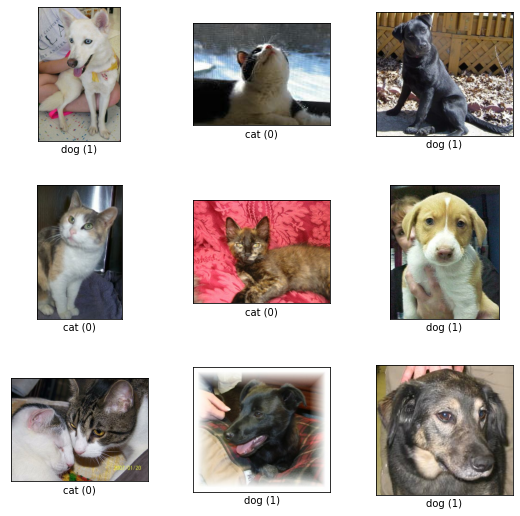

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

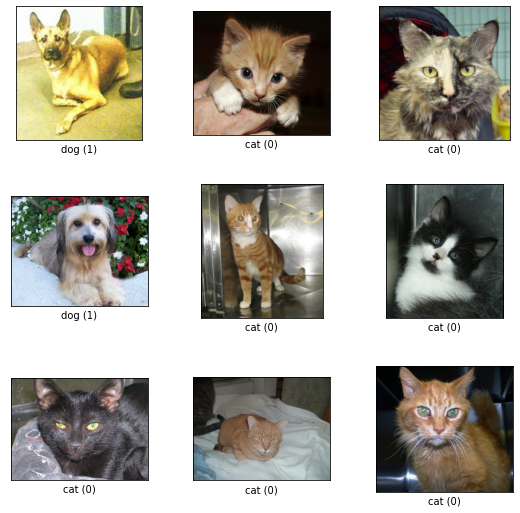

In [7]:
fig = tfds.show_examples(ds_test, ds_info)

(316, 300, 3)
0


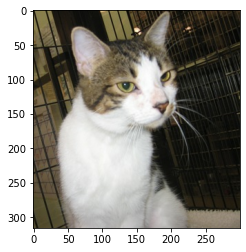

In [8]:
for data in ds_train.take(1):
    plt.imshow(data['image'])
    print(data['image'].shape)
    print(data['label'].numpy())

![resnet](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

In [18]:
# function for building resnet Block
# blocknum은 레이어의 이름
# input_layer 요약 출력을 위해서사용

def build_resnet34_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    _kernal_size = 3
                   ):
    # 입력 레이어
    x = input_layer
    shortcut_layer = input_layer

    # CNN 레이어 커널 3by3
    # x = func()(x) 구조 레이어 변수에 계속 누적된다.
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(_kernal_size,_kernal_size),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num * 2}',
            use_bias=False #배치노말에 이미 편향 들
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)
        x = keras.layers.Activation('relu'
        )(x)
        
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(_kernal_size,_kernal_size),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num * 2 + 1}',
            use_bias=False #배치노말에 이미 편향 들어감
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)

        shortcut_layer = keras.layers.BatchNormalization(
        )(shortcut_layer)

        x = keras.layers.Add()([x,shortcut_layer])

        x = keras.layers.Activation('relu'
        )(x)

        shortcut_layer = x 


        
  

    # Max Pooling 레이어
    # 2by2 stri 2
    # x = keras.layers.MaxPooling2D(
    #     pool_size=(2, 2),
    #     strides=2,
    #     name=f'block{block_num}_pooling'
    # )(x)
    #레이를를 반환
    return x

In [14]:
def build_resnet34_init(input_layer):

    x = input_layer
    x = keras.layers.Conv2D(
            filters=64,
            kernel_size=(7,7),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block1_conv1',
            use_bias=False, #배치노말에 이미 편향 들
            strides=(2, 2)
        )(x)

    x = keras.layers.BatchNormalization(
    )(x)

    x = keras.layers.BActivation('relu'
    )(x)

    x = keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)

    return x
    

In [17]:

def build_resnet34(input_shape=(32,32,3),is_50 = False):

    resnet_input_layer = keras.layers.Input(input_shape=(32,32,3))   # 입력 레이어 생성

    resnet_block_output = build_resnet34_init(resnet_input_layer) 
    resnet_block_output = build_resnet34_block(resnet_block_output,block_num=2) 

    model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

    model.summary()

build_resnet34()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 16, 16, 64)   9408        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 7, 7, 64)     0           block1_conv1[0][0]               
__________________________________________________________________________________________________
block2_conv0 (Conv2D)           (None, 7, 7, 64)     36864       max_pooling2d_4[0][0]            
____________________________________________________________________________________________